Tomato Crop Yield Prediction using LSTM and TCN
Roll nos
2020-EE-61
2020-EE-58
2020-EE-174 

Calculate stats wrt 2 days and make new file

In [ ]:
import pandas as pd


# Read the excel file
# we do so for all files 1 to 13 this is a general code
df = pd.read_excel('tomato_sensor_data13.xlsx')

# Convert the TimeStamp column to datetime format
df['TimeStamp'] = pd.to_datetime(df['Timestamp'])

# Define the fields to process (excluding TimeStamp)
data_fields = df.columns[1:10]
print(data_fields)

# Create an empty list to store results
results = []

# Loop through the data with a step size of 2 days
for i in range(0, len(df), 576):
  # Get the data for the current 2-day interval
  data_subset = df[i:i+576]

  # Calculate min, max, mean, and standard deviation for each data field
  stats = {}
  for field in data_fields:
    stats[f"{field}_min"] = data_subset[field].min()
    stats[f"{field}_max"] = data_subset[field].max()
    stats[f"{field}_mean"] = data_subset[field].mean()
    stats[f"{field}_std"] = data_subset[field].std()

  # Append the calculated statistics to the results list
  results.append(stats)

# Create a pandas dataframe from the results list
df_results = pd.DataFrame(results)

# Write the dataframe to a new excel file
df_results.to_excel('stats13.xlsx', index=False)
# we find stats1 to stats13



Index(['Temperature (°C)', 'Humidity (%)', 'CO2 Concentration (ppm)',
       'Soil Moisture (%)', 'Nitrogen (mg/kg)', 'Phosphorus (mg/kg)',
       'Potassium (mg/kg)', 'pH', 'Light Intensity (lux)'],
      dtype='object')


add 2 cols from yield file

In [ ]:
def add_yield_data(main_file, yield_file, output_file):
  """
  This function reads two excel files, selects 2 columns from the yield data file,
  and adds them to the processed data from the main file. Saves the result to a new file.

  Args:
    main_file: Path to the main excel file with processed data (36 columns).
    yield_file: Path to the yield data excel file.
    output_file: Path to save the new excel file with combined data.
  """
  # Read the processed data file
  df_processed = pd.read_excel(main_file)

  # Read the yield data file
  df_yield = pd.read_excel(yield_file)

  # Select the desired columns from yield data (assuming 2 columns)
  yield_data = df_yield.iloc[:, :2]  # Select first 2 columns

  # Add the yield data columns to the processed dataframe
  df_combined = pd.concat([df_processed, yield_data], axis=1)

  # Save the combined dataframe to a new excel file
  df_combined.to_excel(output_file, index=False)

  print(f"Yield data added! Combined file saved to {output_file}")

# Replace placeholders with your actual file paths
main_file = 'your_processed_data.xlsx'  # Replace with processed data file path
yield_file = 'yield_data.xlsx'
output_file = 'combined_data.xlsx'

add_yield_data('stats1.xlsx','tomato_yield_data1.xlsx', 'yield_trend1.xlsx')
#once again generic rule. 13 files each (1-13)

Yield data added! Combined file saved to yield_trend1.xlsx


Using sklearn, numpy and tensorflow metrics to preprocess data. This block contains a function to read all 13 excel files, another function to normalize the data values using sklearn standard scalar. Input output and time series variables are isolated in prepare_data and split data functions combined and training dataset is finalized

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Read Excel files
def read_excel_files(file_prefix, num_files, num_rows=60):
    dfs = []
    for i in range(1, num_files + 1):
        file_name = f"{file_prefix}{i}.xlsx"
        df = pd.read_excel(file_name, nrows=num_rows)
        dfs.append(df)
    return dfs

# Normalize data
def normalize_data(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Prepare data for LSTM and TCN
def prepare_data(dfs):
    data = pd.concat(dfs, axis=0)

    # Extract features and target
    features = data.iloc[:, :-1].values  # Exclude 'Age (days)' and 'Crop Yield (kg)'
    target = data.iloc[:, -1].values  # 'Crop Yield (kg)'

    # Normalize features
    features, scaler = normalize_data(features)

    return features, target, scaler

# Split data into train and test sets
def split_data(features, target, train_size=10*60):
    train_features = features[:train_size]
    train_target = target[:train_size]
    test_features = features[train_size:]
    test_target = target[train_size:]
    return train_features, train_target, test_features, test_target

# Load data
file_prefix = "yield_trend"  # Replace with your file prefix
num_files = 13
dfs = read_excel_files(file_prefix, num_files)
features, target, scaler = prepare_data(dfs)
train_features, train_target, test_features, test_target = split_data(features, target)

# Create TensorFlow Dataset
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_target)).shuffle(buffer_size=10000).batch(batch_size)


Model Class. The Temporal Convolution Network (TCN) consists of series of ResNet blocks with dilated convolution, hence a residual block class is created whose instance is created in the TCN class which is simply a series of dilated ResNets. Then the LSTM class helps join the standard tf.keras lstm block with the tcn block we just wrote. The parameters are specified and model is initialized.

In [ ]:
# TCN block
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size, dilation):
        super(ResidualBlock, self).__init__()

        self.conv1 = tf.keras.layers.Conv1D(out_channels, kernel_size, dilation_rate=dilation, padding='causal')
        self.conv2 = tf.keras.layers.Conv1D(out_channels, kernel_size, dilation_rate=dilation, padding='causal')
        self.downsample = tf.keras.layers.Conv1D(out_channels, 1, strides=1) if out_channels != 1 else None
        self.relu = tf.keras.layers.ReLU()

    def call(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

# TCN network
class TCN(tf.keras.Model):
    def __init__(self, output_size, kernel_size, num_blocks, num_channels=64):
        super(TCN, self).__init__()

        self.tcn = [ResidualBlock(num_channels, kernel_size, 2 ** i) for i in range(num_blocks)]
        self.tcn = tf.keras.Sequential(self.tcn)

        self.conv_output = tf.keras.layers.Conv1D(output_size, 1)

    def call(self, x):
        x = self.tcn(x)

        # Output layer
        x = self.conv_output(x)
        return x

# LSTM + TCN Model
class LSTMTCN(tf.keras.Model):
    def __init__(self, hidden_size, output_size, num_layers, kernel_size, num_blocks):
        super(LSTMTCN, self).__init__()

        # LSTM layer
        self.lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=True)

        # TCN layers
        self.tcn = TCN(output_size, kernel_size, num_blocks)

        # Fully connected layer
        self.fc = tf.keras.layers.Dense(output_size,activation='relu')


    def call(self, x):
        lstm_out = self.lstm(x)

        # Reshape LSTM output for TCN
        lstm_out = tf.transpose(lstm_out, perm=[0, 2, 1])

        # TCN layers
        tcn_out = self.tcn(lstm_out)

        # Flatten TCN output
        tcn_out = tf.reshape(tcn_out, (tf.shape(tcn_out)[0], -1))

        # Fully connected layer
        output = self.fc(tcn_out)

        return output

# Initialize model
hidden_size = 64
output_size = 1
num_layers = 1
kernel_size = 2
num_blocks = 4

model = LSTMTCN(hidden_size, output_size, num_layers, kernel_size, num_blocks)


model is trained using 50 Epochs and loss is printed at each Epoch. MSE loss is used

In [ ]:
# Loss function
loss_object = tf.keras.losses.MeanSquaredError()

# Optimizer
optimizer = tf.keras.optimizers.Adam()

# Training function
def train_step(features, labels):
    features = tf.expand_dims(features, axis=1)  # Add sequence length dimension
    with tf.GradientTape() as tape:
        predictions = model(features, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Testing function
def test_step(features, labels):
    features = tf.expand_dims(features, axis=1)  # Add sequence length dimension
    predictions = model(features, training=False)
    return loss_object(labels, predictions)

# Training loop
epochs = 50
for epoch in range(epochs):
    for features, labels in train_dataset:
        loss = train_step(features, labels)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy():.4f}")




Epoch 1, Loss: 20.8554
Epoch 2, Loss: 18.6244
Epoch 3, Loss: 10.7210
Epoch 4, Loss: 3.4531
Epoch 5, Loss: 3.2735
Epoch 6, Loss: 1.5555
Epoch 7, Loss: 0.5914
Epoch 8, Loss: 0.6202
Epoch 9, Loss: 0.9101
Epoch 10, Loss: 0.4968
Epoch 11, Loss: 0.5327
Epoch 12, Loss: 0.1954
Epoch 13, Loss: 0.3070
Epoch 14, Loss: 0.1599
Epoch 15, Loss: 0.1150
Epoch 16, Loss: 0.2451
Epoch 17, Loss: 0.2516
Epoch 18, Loss: 0.3770
Epoch 19, Loss: 0.1542
Epoch 20, Loss: 0.0867
Epoch 21, Loss: 0.0681
Epoch 22, Loss: 0.0778
Epoch 23, Loss: 0.1611
Epoch 24, Loss: 0.0804
Epoch 25, Loss: 0.2094
Epoch 26, Loss: 0.1256
Epoch 27, Loss: 0.2767
Epoch 28, Loss: 0.1089
Epoch 29, Loss: 0.0325
Epoch 30, Loss: 0.0717
Epoch 31, Loss: 0.0945
Epoch 32, Loss: 0.0723
Epoch 33, Loss: 0.1362
Epoch 34, Loss: 0.0899
Epoch 35, Loss: 0.1262
Epoch 36, Loss: 0.0916
Epoch 37, Loss: 0.1364
Epoch 38, Loss: 0.1477
Epoch 39, Loss: 0.1243
Epoch 40, Loss: 0.1260
Epoch 41, Loss: 0.1537
Epoch 42, Loss: 0.0796
Epoch 43, Loss: 0.0395
Epoch 44, Loss: 0

Testing: The testing methodology involves evaluating the model's performance using the Root Mean Square Error (RMSE) metric. The test_model function takes the model, test features, test targets, scaler, and the number of samples to be tested as inputs. It first normalizes the test features using the provided scaler and then predicts the yield values. The predicted values are then inverse transformed to obtain the actual yield values. The testing is conducted for varying numbers of samples ranging from 1 to 59, and the RMSE is printed for each set of samples. This is done because we wanted to analyse the performance of model prediction based on the yield values provided and the ones predicted. 1 here means what in a sequence of 60 yield values, the first one is provided with input features and the rest 59 are predicted and compared with actual ones. Input features of all are provided. Then we increase the number of initial sequence values provided and this decreases the amount of values predicted and we evaluate the performance of the model depending on how much information it has regarding the current crop cycle. To visually assess the model's predictions, line graphs are plotted comparing the actual and predicted yields for different initial yield values. The initial_yields list specifies the different initial yield values to be tested. For each initial yield, the model is tested using the test_model function, and the actual and predicted yields are printed.

In [ ]:
# Test the model
def test_model(model, test_features, test_target, scaler, num_samples):
    test_features = test_features[:num_samples]
    test_target = test_target[:num_samples]

    # Normalize test features
    test_features = scaler.transform(test_features.reshape(-1, test_features.shape[-1])).reshape(-1, 1, test_features.shape[-1])

    # Predict
    predictions = model.predict(test_features)

    # Inverse transform to get the actual values
    predictions = scaler.inverse_transform(np.concatenate((test_features[:, :, :-1].reshape(-1, test_features.shape[-1] - 1), predictions.reshape(-1, 1)), axis=1))[:, -1]
    actual = scaler.inverse_transform(np.concatenate((test_features[:, :, :-1].reshape(-1, test_features.shape[-1] - 1), test_target.reshape(-1, 1)), axis=1))[:, -1]

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual, predictions))

    return rmse/1000, actual, predictions

num_samples_list = [i for i in range(1,60)]
for num_samples in num_samples_list:
    rmse, actual, predicted = test_model(model, test_features, test_target, scaler, num_samples)
    print(f"RMSE for {num_samples} samples: {rmse}")

1/1 [==============================] - 0s 22ms/step
RMSE for 1 samples: 0.20016184187727534
1/1 [==============================] - 0s 22ms/step
RMSE for 2 samples: 0.3212897590560851
1/1 [==============================] - 0s 22ms/step
RMSE for 3 samples: 0.3063213848866969
1/1 [==============================] - 0s 22ms/step
RMSE for 4 samples: 0.30129520376416824
1/1 [==============================] - 0s 24ms/step
RMSE for 5 samples: 0.3109340884985199
1/1 [==============================] - 0s 26ms/step
RMSE for 6 samples: 0.3127885561583035
1/1 [==============================] - 0s 24ms/step
RMSE for 7 samples: 0.28968308653218455
1/1 [==============================] - 0s 24ms/step
RMSE for 8 samples: 0.28075311824063287
1/1 [==============================] - 0s 23ms/step
RMSE for 9 samples: 0.2861545712285292
1/1 [==============================] - 0s 32ms/step
RMSE for 10 samples: 0.28541978001259705
1/1 [==============================] - 0s 25ms/step
RMSE for 11 samples: 0.284494059

some sample values of initial yield in grams are taken so see what are the predicted yields in the rest of the sequence, performance is not great due to lack of data, we need around 150-200 cycles of tomato crop to get this model working smoothly.
 Subsequently, a line graph is plotted using matplotlib.pyplot to visualize the actual and predicted yields against the age in days (from 0 to the current initial yield). The x-axis is labeled as "Age (days)", and the y-axis represents the yield. The predicted yields are scaled down by a factor of 6 for better visualization.

Testing with initial yield of 5 g:
1/1 [==============================] - 0s 35ms/step
RMSE: 0.3109
Actual Yields: [62.38544818259893, 63.77089636519785, 65.15634454779678, 66.5417927303957, 69.31268909559356]/6
Predicted Yields: [262.54727354404497, 471.67954081467303, 339.0980930602445, 352.22850771461617, 416.13373474718065]
--------------------------------------------------


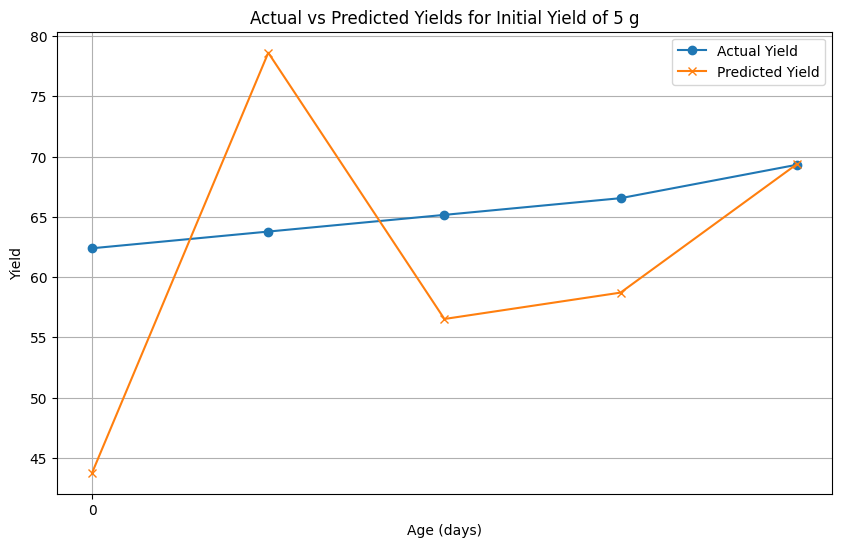

Testing with initial yield of 10 g:
1/1 [==============================] - 0s 46ms/step
RMSE: 0.2854
Actual Yields: [62.38544818259893, 63.77089636519785, 65.15634454779678, 66.5417927303957, 69.31268909559356, 71.04449932384222, 72.77630955209088, 74.1617577346898, 75.89356796293845, 81.08899864768442]/6
Predicted Yields: [262.54727354404497, 471.67954081467303, 339.0980930602445, 352.22850771461617, 416.13373474718065, 392.94518001518526, 92.62428089316953, 281.9223728252964, 402.05524542447415, 359.8085136607339]
--------------------------------------------------


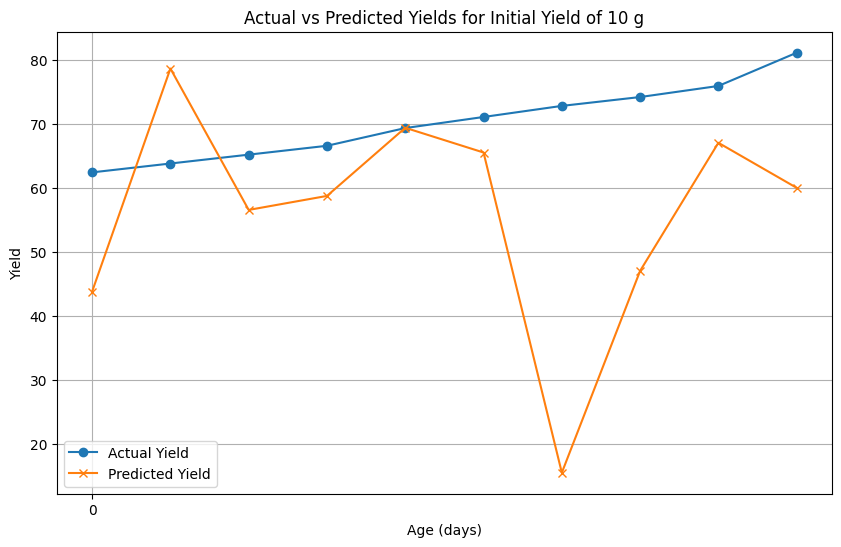

Testing with initial yield of 15 g:
1/1 [==============================] - 0s 47ms/step
RMSE: 0.2723
Actual Yields: [62.38544818259893, 63.77089636519785, 65.15634454779678, 66.5417927303957, 69.31268909559356, 71.04449932384222, 72.77630955209088, 74.1617577346898, 75.89356796293845, 81.08899864768442, 82.82080887593308, 84.89898114983147, 86.97715342372986, 89.05532569762825, 97.02165274757208]/6
Predicted Yields: [262.54727354404497, 471.67954081467303, 339.0980930602445, 352.22850771461617, 416.13373474718065, 392.94518001518526, 92.62428089316953, 281.9223728252964, 402.05524542447415, 359.8085136607339, 357.88636840865837, 349.08247344396557, 300.35417051289676, 280.44268664166015, 361.5721069509947]
--------------------------------------------------


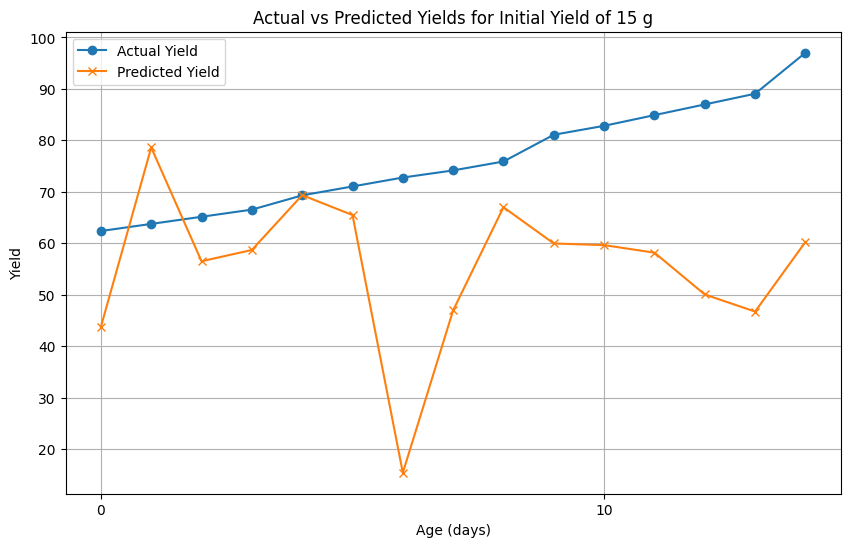

Testing with initial yield of 20 g:
1/1 [==============================] - 0s 92ms/step
RMSE: 0.2732
Actual Yields: [62.38544818259893, 63.77089636519785, 65.15634454779678, 66.5417927303957, 69.31268909559356, 71.04449932384222, 72.77630955209088, 74.1617577346898, 75.89356796293845, 81.08899864768442, 82.82080887593308, 84.89898114983147, 86.97715342372986, 89.05532569762825, 97.02165274757208, 99.4461870671202, 101.87072138666832, 103.94889366056671, 106.37342798011483, 118.49609957785543]/6
Predicted Yields: [262.54727354404497, 471.67954081467303, 339.0980930602445, 352.22850771461617, 416.13373474718065, 392.94518001518526, 92.62428089316953, 281.9223728252964, 402.05524542447415, 359.8085136607339, 357.88636840865837, 349.08247344396557, 300.35417051289676, 280.442587546684, 361.5721069509947, 514.5261935639298, 228.80723439574166, 244.8952707394741, 228.67365436791272, 515.457289959687]
--------------------------------------------------


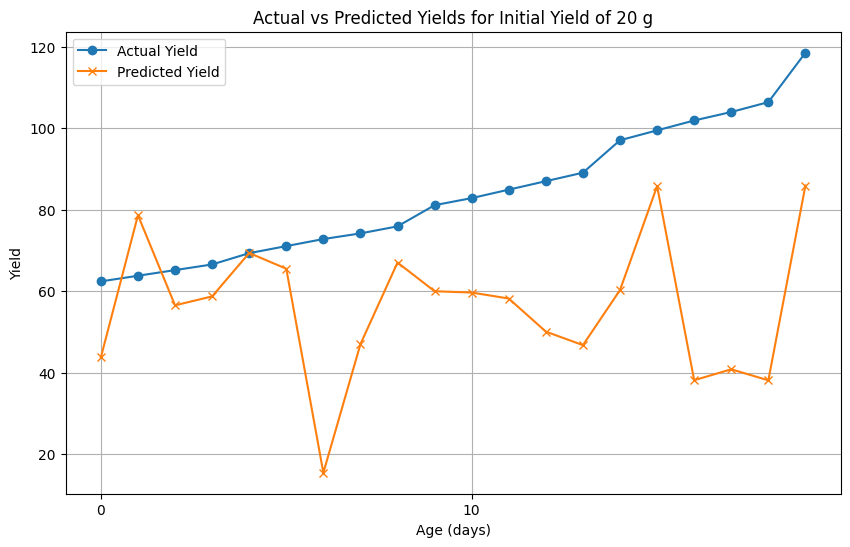

Testing with initial yield of 25 g:
1/1 [==============================] - 0s 61ms/step
RMSE: 0.2700
Actual Yields: [62.38544818259893, 63.77089636519785, 65.15634454779678, 66.5417927303957, 69.31268909559356, 71.04449932384222, 72.77630955209088, 74.1617577346898, 75.89356796293845, 81.08899864768442, 82.82080887593308, 84.89898114983147, 86.97715342372986, 89.05532569762825, 97.02165274757208, 99.4461870671202, 101.87072138666832, 103.94889366056671, 106.37342798011483, 118.49609957785543, 121.26699594305327, 124.03789230825113, 127.15515071909871, 129.92604708429656, 147.24414936678315]/6
Predicted Yields: [262.54727354404497, 471.67954081467303, 339.0980930602445, 352.22850771461617, 416.13373474718065, 392.94518001518526, 92.62428089316953, 281.9223728252964, 402.05524542447415, 359.8085136607339, 357.88636840865837, 349.08247344396557, 300.35417051289676, 280.442587546684, 361.5721069509947, 514.5261935639298, 228.80723439574166, 244.8952707394741, 228.67365436791272, 515.457256

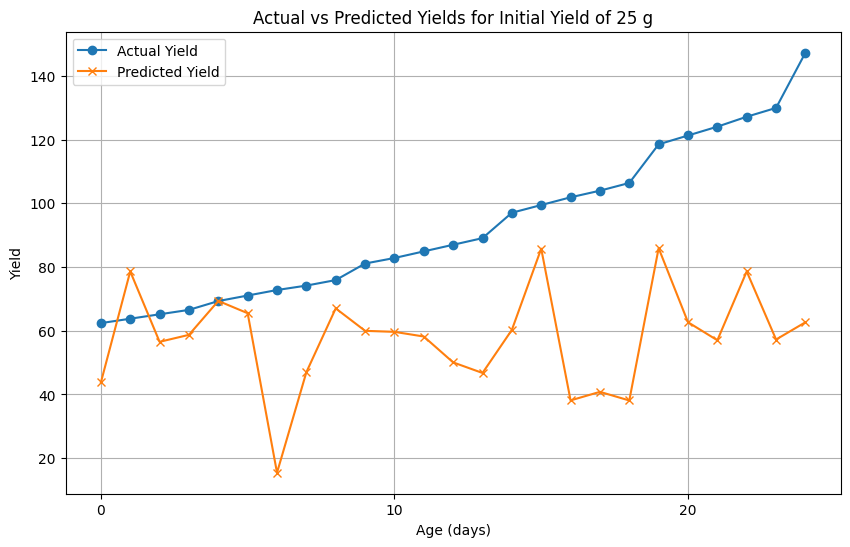

Testing with initial yield of 30 g:
1/1 [==============================] - 0s 59ms/step
RMSE: 0.2631
Actual Yields: [62.38544818259893, 63.77089636519785, 65.15634454779678, 66.5417927303957, 69.31268909559356, 71.04449932384222, 72.77630955209088, 74.1617577346898, 75.89356796293845, 81.08899864768442, 82.82080887593308, 84.89898114983147, 86.97715342372986, 89.05532569762825, 97.02165274757208, 99.4461870671202, 101.87072138666832, 103.94889366056671, 106.37342798011483, 118.49609957785543, 121.26699594305327, 124.03789230825113, 127.15515071909871, 129.92604708429656, 147.24414936678315, 150.70776982328044, 154.17139027977777, 157.6350107362751, 161.09863119277242, 184.99761234260387]/6
Predicted Yields: [262.54727354404497, 471.67954081467303, 339.0980930602445, 352.22850771461617, 416.13373474718065, 392.94518001518526, 92.62428089316953, 281.9223728252964, 402.05524542447415, 359.8085136607339, 357.88636840865837, 349.08247344396557, 300.35417051289676, 280.442587546684, 361.5721

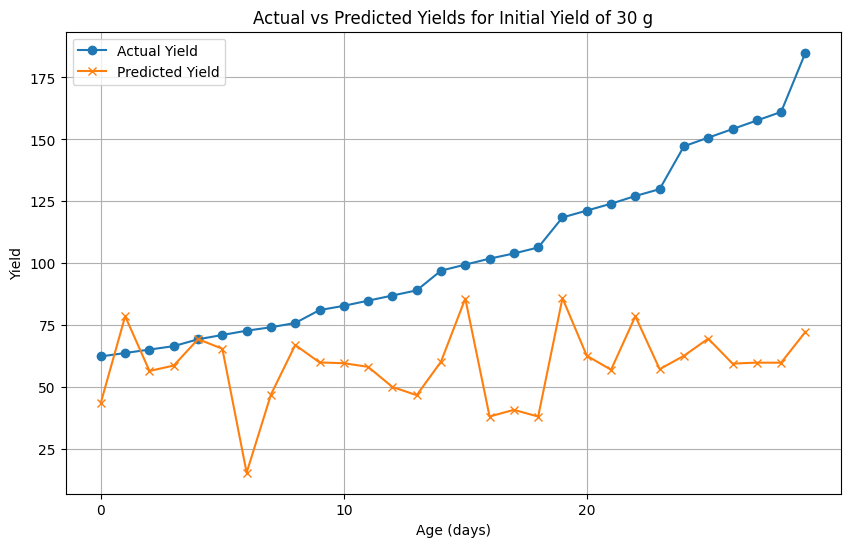

Testing with initial yield of 35 g:
2/2 [==============================] - 0s 10ms/step
RMSE: 0.2461
Actual Yields: [62.38544818259893, 63.77089636519785, 65.15634454779678, 66.5417927303957, 69.31268909559356, 71.04449932384222, 72.77630955209088, 74.1617577346898, 75.89356796293845, 81.08899864768442, 82.82080887593308, 84.89898114983147, 86.97715342372986, 89.05532569762825, 97.02165274757208, 99.4461870671202, 101.87072138666832, 103.94889366056671, 106.37342798011483, 118.49609957785543, 121.26699594305327, 124.03789230825113, 127.15515071909871, 129.92604708429656, 147.24414936678315, 150.70776982328044, 154.17139027977777, 157.6350107362751, 161.09863119277242, 184.99761234260387, 189.15395689040065, 193.31030143819743, 197.4666459859942, 201.62299053379098, 234.8737469161652]/6
Predicted Yields: [262.54727354404497, 471.67954081467303, 339.0980930602445, 352.22850771461617, 416.13373474718065, 392.94518001518526, 92.62428089316953, 281.9223728252964, 402.05524542447415, 359.808

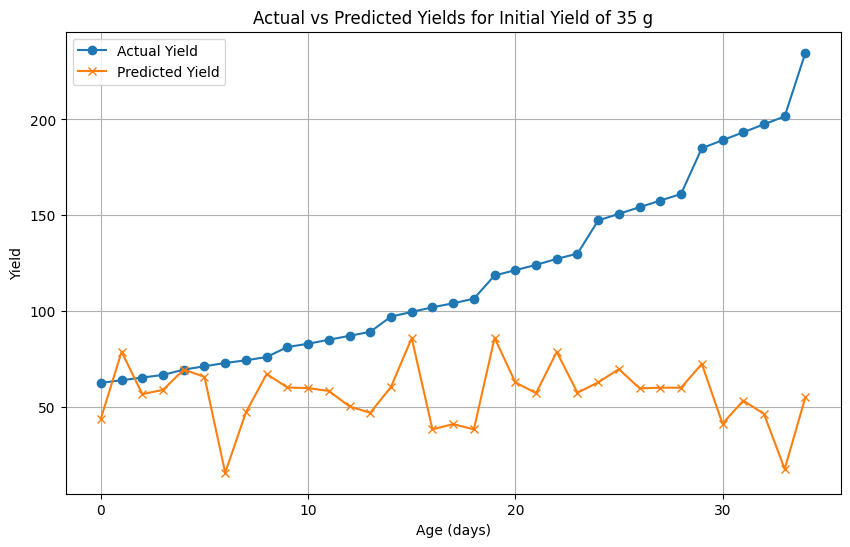

Testing with initial yield of 40 g:
2/2 [==============================] - 0s 12ms/step
RMSE: 0.2311
Actual Yields: [62.38544818259893, 63.77089636519785, 65.15634454779678, 66.5417927303957, 69.31268909559356, 71.04449932384222, 72.77630955209088, 74.1617577346898, 75.89356796293845, 81.08899864768442, 82.82080887593308, 84.89898114983147, 86.97715342372986, 89.05532569762825, 97.02165274757208, 99.4461870671202, 101.87072138666832, 103.94889366056671, 106.37342798011483, 118.49609957785543, 121.26699594305327, 124.03789230825113, 127.15515071909871, 129.92604708429656, 147.24414936678315, 150.70776982328044, 154.17139027977777, 157.6350107362751, 161.09863119277242, 184.99761234260387, 189.15395689040065, 193.31030143819743, 197.4666459859942, 201.62299053379098, 234.8737469161652, 239.72281555526146, 244.5718841943577, 249.76731487910368, 254.61638351819988, 299.2970874070153]/6
Predicted Yields: [262.54727354404497, 471.67954081467303, 339.0980930602445, 352.22850771461617, 416.133

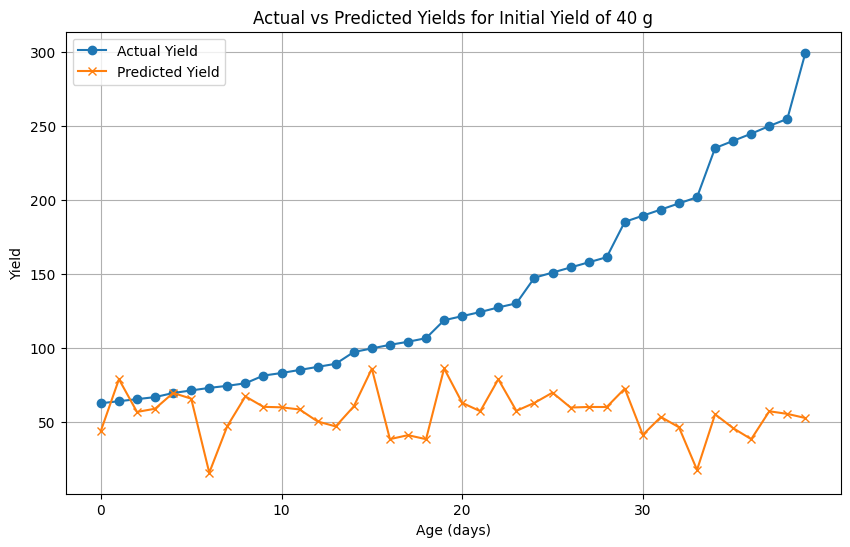

Testing with initial yield of 45 g:
2/2 [==============================] - 0s 18ms/step
RMSE: 0.2202
Actual Yields: [62.38544818259893, 63.77089636519785, 65.15634454779678, 66.5417927303957, 69.31268909559356, 71.04449932384222, 72.77630955209088, 74.1617577346898, 75.89356796293845, 81.08899864768442, 82.82080887593308, 84.89898114983147, 86.97715342372986, 89.05532569762825, 97.02165274757208, 99.4461870671202, 101.87072138666832, 103.94889366056671, 106.37342798011483, 118.49609957785543, 121.26699594305327, 124.03789230825113, 127.15515071909871, 129.92604708429656, 147.24414936678315, 150.70776982328044, 154.17139027977777, 157.6350107362751, 161.09863119277242, 184.99761234260387, 189.15395689040065, 193.31030143819743, 197.4666459859942, 201.62299053379098, 234.8737469161652, 239.72281555526146, 244.5718841943577, 249.76731487910368, 254.61638351819988, 299.2970874070153, 305.1852421830607, 311.07339695910616, 317.3079137808013, 323.19606855684674, 382.77034040860053]/6
Predict

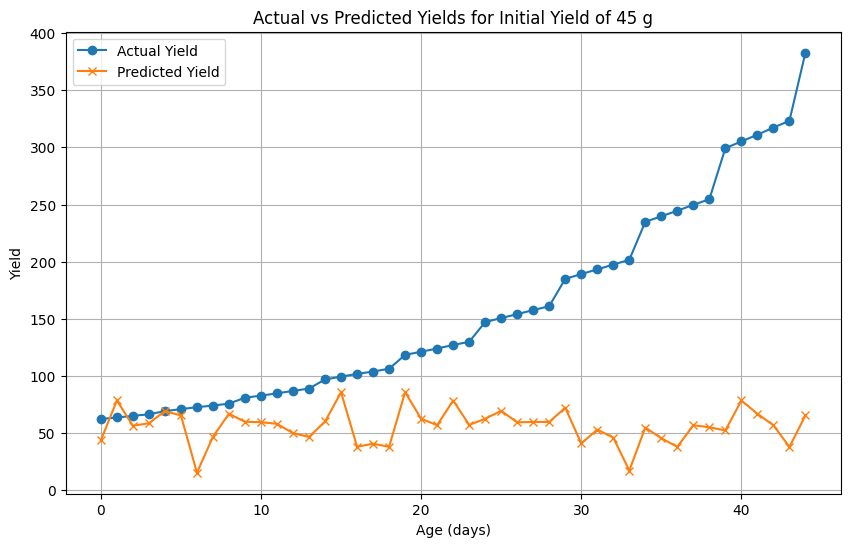

Testing with initial yield of 50 g:
2/2 [==============================] - 0s 16ms/step
RMSE: 0.2104
Actual Yields: [62.38544818259893, 63.77089636519785, 65.15634454779678, 66.5417927303957, 69.31268909559356, 71.04449932384222, 72.77630955209088, 74.1617577346898, 75.89356796293845, 81.08899864768442, 82.82080887593308, 84.89898114983147, 86.97715342372986, 89.05532569762825, 97.02165274757208, 99.4461870671202, 101.87072138666832, 103.94889366056671, 106.37342798011483, 118.49609957785543, 121.26699594305327, 124.03789230825113, 127.15515071909871, 129.92604708429656, 147.24414936678315, 150.70776982328044, 154.17139027977777, 157.6350107362751, 161.09863119277242, 184.99761234260387, 189.15395689040065, 193.31030143819743, 197.4666459859942, 201.62299053379098, 234.8737469161652, 239.72281555526146, 244.5718841943577, 249.76731487910368, 254.61638351819988, 299.2970874070153, 305.1852421830607, 311.07339695910616, 317.3079137808013, 323.19606855684674, 382.77034040860053, 389.69758

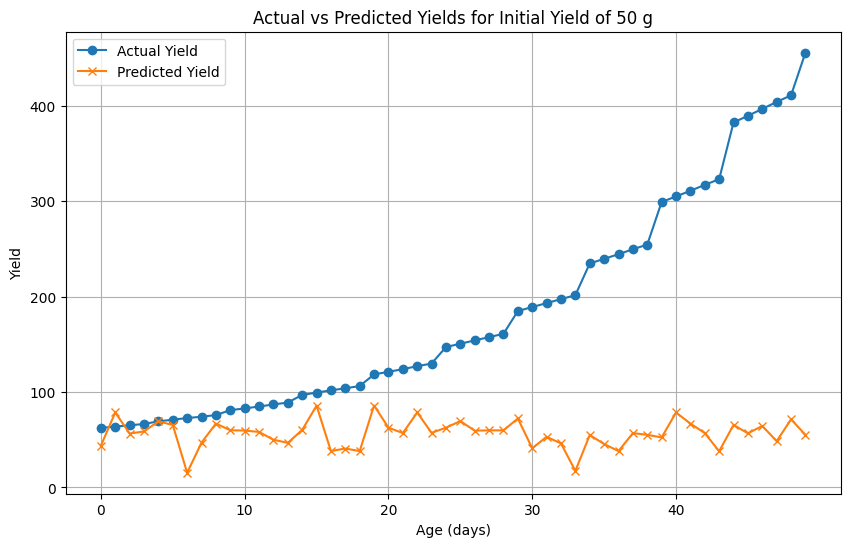

In [ ]:
import matplotlib.pyplot as plt

# Read files
file_prefix = "yield_trend"  # Replace with your file prefix
dfs_test = read_excel_files(file_prefix, 3)

# Prepare test data
test_features, test_target, _ = prepare_data(dfs_test)

# Define the initial values of yield to test
initial_yields = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# Test the model with different initial values
for initial_yield in initial_yields:
    print(f"Testing with initial yield of {initial_yield} g:")
    rmse, actual, predicted = test_model(model, test_features, test_target, scaler, initial_yield)
    print(f"RMSE: {rmse:.4f}")
    print(f"Actual Yields: {actual[:initial_yield].tolist()}/6")
    print(f"Predicted Yields: {predicted[:initial_yield].tolist()}")
    print("-" * 50)

       # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(0, initial_yield), actual[:initial_yield], label='Actual Yield', marker='o')
    plt.plot(range(0, initial_yield), predicted[:initial_yield]/6, label='Predicted Yield', marker='x')
    plt.title(f"Actual vs Predicted Yields for Initial Yield of {initial_yield} g")
    plt.xlabel("Age (days)")
    plt.ylabel("Yield")
    plt.xticks(range(0, initial_yield, 10))  # Setting x-axis ticks
    plt.legend()
    plt.grid(True)
    plt.show()